In [1]:
# time series for predict, packages
import multiprocessing
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as run

In [2]:
# tensorflow version
import pkg_resources
print(pkg_resources.get_distribution("tensorflow").version)

1.1.0


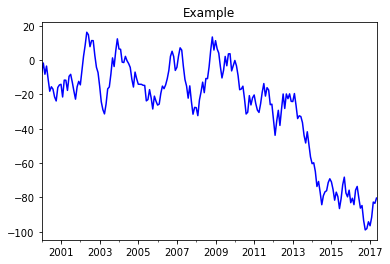

In [3]:
random.seed(100)
rng = pd.date_range(start='2000', periods =209,freq='M')
ts = pd.Series(np.random.uniform(-10,10,size=len(rng)),rng).cumsum()
ts.plot(c='b', title="Example")
plt.show()

In [4]:
ts.head(10)

2000-01-31    -7.128065
2000-02-29    -1.725580
2000-03-31    -8.255631
2000-04-30    -3.488856
2000-05-31   -11.152315
2000-06-30   -18.159149
2000-07-31   -15.561426
2000-08-31   -16.932819
2000-09-30   -21.460282
2000-10-31   -23.817011
Freq: M, dtype: float64

In [5]:
TS = np.array(ts)
num_periods = 20  # 10 batches , 20 values per batch
f_horizon = 1  # Forecast Horizon, 1 period into future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]    #x_data len is truncated from 209 to 200
x_batches = x_data.reshape(-1,20,1)

y_data = TS[1:(len(TS)-len(TS) % num_periods)+f_horizon]
y_batches = y_data.reshape(-1,20,1)


print(len(x_batches))
print(x_batches.shape)
#print(x_batches[0:1])

print(y_batches.shape)
#print(y_batches[0:1])

10
(10, 20, 1)
(10, 20, 1)


In [6]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods+forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,20,1)
    testY = TS[-(num_periods):].reshape(-1,20,1)
    return testX, testY

In [7]:
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
# print(X_test)
print(Y_test.shape)
# print(Y_test)

(1, 20, 1)
(1, 20, 1)


In [8]:
def run_tensorflow():
    # https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution
    tf.reset_default_graph()

    num_periods = 20  #number of periods per vector used to predict one period ahead
    inputs = 1        #number of vectors submitted 
    hidden = 100      #number of neurons we will recursively work through
    output = 1        #number of output vector

    X = tf.placeholder(tf.float32, [None, num_periods, inputs ])
    y = tf.placeholder(tf.float32, [None, num_periods, output ])

    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
    rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)   # dynamic instead of static

    learning_rate =0.001

    stacked_rnn_output = tf.reshape(rnn_output,[-1, hidden])     # changed the form into a tensor
    stacked_outputs = tf.layers.dense(stacked_rnn_output, output)  # GD
    outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

    loss = tf.reduce_sum(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    epochs = 2000
    # https://stackoverflow.com/questions/39758094/clearing-tensorflow-gpu-memory-after-model-execution
    # https://github.com/tensorflow/tensorflow/issues/1578
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)

    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        init.run()
        for i in range(epochs):
            sess.run(training_op, feed_dict={X: x_batches, y:y_batches})
            if i % 100 == 0:
                mse = loss.eval(feed_dict={X:x_batches, y:y_batches})
                print(i, "\tMSE:", mse)
        y_pred = sess.run(outputs, feed_dict={X: X_test})

    # draw data for reference to check
    plt.title("Forecast vs Actual")
    plt.plot(pd.Series(np.ravel(Y_test)),"bo", markersize=10, label =" Actual")
    plt.plot(pd.Series(np.ravel(y_pred)),"r.", markersize=10, label =" Forecast")
    plt.legend(loc="lower left")
    plt.show()

0 	MSE: 300486.0
100 	MSE: 8969.33
200 	MSE: 4055.43
300 	MSE: 1724.68
400 	MSE: 1040.26
500 	MSE: 832.927
600 	MSE: 746.374
700 	MSE: 663.526
800 	MSE: 619.468
900 	MSE: 588.947
1000 	MSE: 582.675
1100 	MSE: 552.744
1200 	MSE: 533.76
1300 	MSE: 743.423
1400 	MSE: 510.537
1500 	MSE: 496.45
1600 	MSE: 483.015
1700 	MSE: 473.664
1800 	MSE: 461.772
1900 	MSE: 452.277


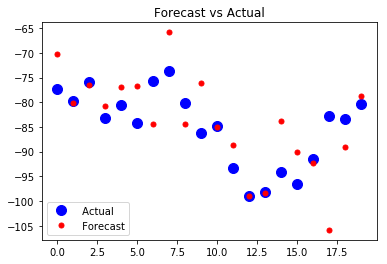

In [9]:
# option 1: execute code with extra process
p = multiprocessing.Process(target=run_tensorflow)
p.start()
p.join()